# 16. Confidence intervals of average temperatures

See Notebook 8 for a description of the calibration procedure. This notebook is about the confidence intervals estimation using measurements from a double ended setup.

## Calibration procedure

In [1]:
import os

from dtscalibration import read_silixa_files
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
filepath = os.path.join('..', '..', 'tests', 'data', 'double_ended2')

ds_ = read_silixa_files(
    directory=filepath,
    timezone_netcdf='UTC',
    file_ext='*.xml')

ds = ds_.sel(x=slice(0, 100))  # only calibrate parts of the fiber
sections = {
    'probe1Temperature': [slice(7.5, 17.), slice(70., 80.)],  # cold bath
    'probe2Temperature': [slice(24., 34.), slice(85., 95.)],  # warm bath
    }
ds.sections = sections

6 files were found, each representing a single timestep
6 recorded vars were found: LAF, ST, AST, REV-ST, REV-AST, TMP
Recorded at 1693 points along the cable
The measurement is double ended
Reading the data from disk


/home/bart/git/travis_fix/python-dts-calibration/src/dtscalibration/io.py:1843: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  'time', pd.DatetimeIndex(v).tz_convert(timezone_netcdf).astype(


In [3]:
st_var, resid = ds.variance_stokes(st_label='st')
ast_var, _ = ds.variance_stokes(st_label='ast')
rst_var, _ = ds.variance_stokes(st_label='rst')
rast_var, _ = ds.variance_stokes(st_label='rast')

In [4]:
ds.calibration_double_ended(
    st_var=st_var,
    ast_var=ast_var,
    rst_var=rst_var,
    rast_var=rast_var,
    store_tmpw='tmpw',
    method='wls',
    solver='sparse')

## Confidence intervals of averages
### Introduction confidence intervals
The confidence intervals consist of two sources of uncertainty.

1. Measurement noise in the measured Stokes and anti-Stokes signals. Expressed in a single variance value.
2. Inherent to least squares procedures / overdetermined systems, the parameters are estimated with limited certainty and all parameters are correlated. Which is expressed in the covariance matrix.

Both sources of uncertainty are propagated to an uncertainty in the estimated temperature via Monte Carlo.

Confidence intervals are all computed with `ds.conf_int_double_ended()` and `ds.conf_int_single_ended()`.
The confidence interval can be estimated if the calibration method is `wls` (so that the parameter uncertainties are estimated), `st_var`, `ast_var`, `rst_var`, `rast_var` are correctly estimated, and confidence intervals are passed to `conf_ints`. As weigths are correctly passed to the least squares procedure, the covariance matrix can be used as an estimator for the uncertainty in the parameters. This matrix holds the covariances between all the parameters. A large parameter set is generated from this matrix as part of the Monte Carlo routine, assuming the parameter space is normally distributed with their mean at the best estimate of the least squares procedure.

The large parameter set is used to calculate a large set of temperatures. By using `percentiles` or `quantile` the 95% confidence interval of the calibrated temperature between 2.5% and 97.5% are calculated.

Four types of averaging schemes are implemented:
1. Averaging over time while the temperature varies over time and along the fiber
2. Averaging over time while assuming the temperature remains constant over time but varies along the fiber
3. Averaging along the fiber while the temperature varies along the cable and over time
4. Averaging along the fiber while assuming the temperature is same along the fiber but varies over time

These functions only work with the same size DataStore as that was calibrated. If you would like to average only a selection use the keyword arguments `ci_avg_time_sel`, `ci_avg_time_isel`, `ci_avg_x_sel`, `ci_avg_x_isel`.

### 1. Averaging over time while the temperature varies over time and along the fiber

So that you can state: 
- 'We can say with 95% confidence that the temperature remained between this line and this line during the entire measurement period'. 
- The average temperature during the measurement period was ..

Using the default `store_..` values the following DataArrays are added to the DataStore:
```
tmpf_avg1              The average forward temperature
tmpf_mc_avg1_var       The estimated variance of the average forward temperature
tmpf_mc_avg1           The confidence intervals of the average forward temperature

tmpb_avg1              The average backward temperature
tmpb_mc_avg1_var       The estimated variance of the average backward temperature
tmpb_mc_avg1           The confidence intervals of the average forward temperature

tmpw_avg1              The average forward-backward-averaged temperature
tmpw_avg1_var          The estimated variance of the average forward-backward-averaged temperature
tmpw_mc_avg1           The confidence intervals of the average forward-backward-averaged temperature
```


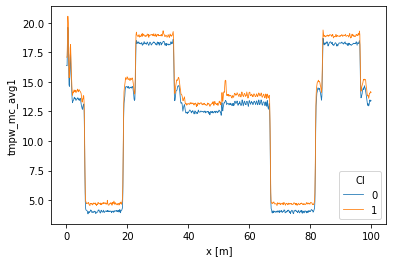

In [5]:
ds.average_double_ended(
    st_var=st_var,
    ast_var=ast_var,
    rst_var=rst_var,
    rast_var=rast_var,
    conf_ints=[2.5, 97.5],
    mc_sample_size=500,  # <- choose a much larger sample size
    ci_avg_time_flag1=True,
    ci_avg_time_flag2=False,
    ci_avg_time_isel=[0, 1, 2, 3, 4, 5],
    ci_avg_time_sel=None)
ds.tmpw_mc_avg1.plot(hue='CI', linewidth=0.8);

### 2. Averaging over time while assuming the temperature remains constant over time but varies along the fiber

So that you can state: 
- 'I want to estimate a background temperature with confidence intervals. I hereby assume the temperature does not change over time and average all measurements to get a better estimate of the background temperature.'

Using the default `store_..` values the following DataArrays are added to the DataStore:
```
tmpf_avg2              The average forward temperature
tmpf_mc_avg2_var       The estimated variance of the average forward temperature
tmpf_mc_avg2           The confidence intervals of the average forward temperature

tmpb_avg2              The average backward temperature
tmpb_mc_avg2_var       The estimated variance of the average backward temperature
tmpb_mc_avg2           The confidence intervals of the average forward temperature

tmpw_avg2              The average forward-backward-averaged temperature
tmpw_avg2_var          The estimated variance of the average forward-backward-averaged temperature
tmpw_mc_avg2           The confidence intervals of the average forward-backward-averaged temperature
```

Note that this average has much less uncertainty that averaging option 1. We can specify specific times with `ci_avg_time_isel`.

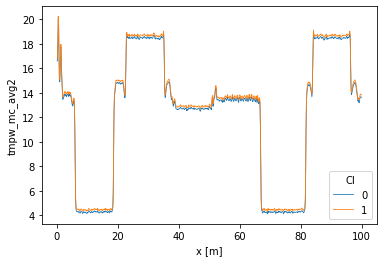

In [6]:
ds.average_double_ended(
    st_var=st_var,
    ast_var=ast_var,
    rst_var=rst_var,
    rast_var=rast_var,
    conf_ints=[2.5, 97.5],
    mc_sample_size=500,  # <- choose a much larger sample size
    ci_avg_time_flag1=False,
    ci_avg_time_flag2=True,
    ci_avg_time_isel=[0, 1, 2, 3, 4, 5],
    ci_avg_time_sel=None)
ds.tmpw_mc_avg2.plot(hue='CI', linewidth=0.8);

### 3. Averaging along the fiber while the temperature varies along the cable and over time

So that you can state: 
- 'The temperature of the fiber remained between these ci bounds at time 2, and at time 3 the temperature of the fiber remained between these ci bounds'.

Using the default `store_..` values the following DataArrays are added to the DataStore:
```
tmpf_avgx1              The average forward temperature
tmpf_mc_avgx1_var       The estimated variance of the average forward temperature
tmpf_mc_avgx1           The confidence intervals of the average forward temperature

tmpb_avgx1              The average backward temperature
tmpb_mc_avgx1_var       The estimated variance of the average backward temperature
tmpb_mc_avgx1           The confidence intervals of the average forward temperature

tmpw_avgx1              The average forward-backward-averaged temperature
tmpw_avgx1_var          The estimated variance of the average forward-backward-averaged temperature
tmpw_mc_avgx1           The confidence intervals of the average forward-backward-averaged temperature
```

Note that this function returns a single average per time step. Use the keyword arguments `ci_avg_x_sel`, `ci_avg_x_isel` to specify specific fiber sections.

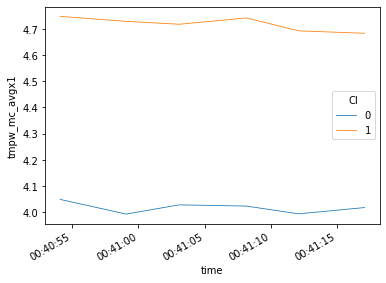

In [7]:
ds.average_double_ended(
    st_var=st_var,
    ast_var=ast_var,
    rst_var=rst_var,
    rast_var=rast_var,
    conf_ints=[2.5, 97.5],
    mc_sample_size=500,  # <- choose a much larger sample size
    ci_avg_x_flag1=True,
    ci_avg_x_flag2=False,
    ci_avg_x_sel=slice(7.5, 17.),
    ci_avg_x_isel=None)
ds.tmpw_mc_avgx1.plot(hue='CI', linewidth=0.8);

### 4. Averaging along the fiber while assuming the temperature is same along the fiber but varies over time

So that you can state: 
- 'I have put a lot of fiber in water, and I know that the temperature variation in the water is much smaller than along other parts of the fiber. And I would like to average the measurements from multiple locations to improve the estimated temperature of the water'.

Using the default `store_..` values the following DataArrays are added to the DataStore:
```
tmpf_avgx2              The average forward temperature
tmpf_mc_avgx2_var       The estimated variance of the average forward temperature
tmpf_mc_avgx2           The confidence intervals of the average forward temperature

tmpb_avgx2              The average backward temperature
tmpb_mc_avgx2_var       The estimated variance of the average backward temperature
tmpb_mc_avgx2           The confidence intervals of the average forward temperature

tmpw_avgx2              The average forward-backward-averaged temperature
tmpw_avgx2_var          The estimated variance of the average forward-backward-averaged temperature
tmpw_mc_avgx2           The confidence intervals of the average forward-backward-averaged temperature
```

Select the part of the fiber that is in the water with `ci_avg_x_sel`.

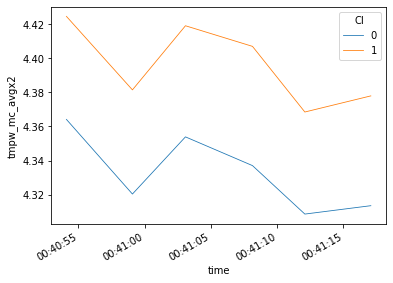

In [8]:
ds.average_double_ended(
    st_var=st_var,
    ast_var=ast_var,
    rst_var=rst_var,
    rast_var=rast_var,
    conf_ints=[2.5, 97.5],
    mc_sample_size=500,  # <- choose a much larger sample size
    ci_avg_x_flag1=False,
    ci_avg_x_flag2=True,
    ci_avg_x_sel=slice(7.5, 17.),
    ci_avg_x_isel=None)
ds.tmpw_mc_avgx2.plot(hue='CI', linewidth=0.8);